In [1]:
#Programming Question
#Regression Dataset - Crimes
##Dataset URL - http://archive.ics.uci.edu/ml/datasets/communities+and+crime

import numpy as np
import urllib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import models, optimizers
from keras import layers, losses
from keras import regularizers
from keras.utils import to_categorical
from keras.layers import BatchNormalization
import keras
import tensorflow as tf
import pandas as pd
import time
get_ipython().run_line_magic('matplotlib', 'inline')


#Setting Random seed
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [10]:
def loaddata():
  url = "http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

  rawdata = urllib.request.urlopen(url)

  dataset = np.genfromtxt(rawdata, dtype = 'float32', missing_values='?', delimiter=',')

  #Delete column for Community Name - String column.
  dataset = np.delete(dataset,3,1)
  
  #Convert column for State to Categorical
  col0Cat = to_categorical(dataset[:,0])
  #Drop column 0 - will be replaced by categorical values
  dataset = np.delete(dataset,0,1)

  #Drop column 1,2 - Too many missing values
  dataset = np.delete(dataset,[0,1],1)

  #Separate predictors and target variable
  x_train, y_train = dataset[:,:-1], dataset[:,-1]

  #Append categorical tensor for state to x_train
  x_train = np.append(x_train, col0Cat, axis = 1)
  
  #Column 26 has 1 missing value - Replace it with mean of that column
  x_train[np.where(np.isnan(x_train[:,26])), 26] = np.nanmean(x_train[:,26])
  
  #Delete Multiple columns with 1675 missing values
  del_cols = [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 120, 122]
  x_train = np.delete(x_train, del_cols, 1)
  

  #Create Train and Test split  
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)
  

  return (x_train, y_train), (x_test, y_test)


In [11]:
def print_graphs(history, epochs, batch_size, smooth = 0, plot_title = "L1 Loss"):
  history_dict = history.history
  mae = history_dict['mae']
  val_mae = history_dict['val_mae']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
    
  fig = plt.figure(figsize=(15,7))
  fig.suptitle(plot_title, fontsize = 14, weight = 'bold')
  plt.subplot(1,2,1)
  plt.plot(range(epochs), mae, 'r', label = 'Train MAE')
  plt.plot(range(epochs), val_mae, 'b', label = 'Validation MAE')
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(range(epochs), loss, 'r', label = 'Train Loss')
  plt.plot(range(epochs), val_loss, 'b', label = 'Validation Loss')
  
  plt.legend()
  plt.show()
  
  
def define_model(num_layers = 1, num_neurons = [16], input_shape = (0,), 
                 loss = "L1", optimizer = "RMSprop", optimizer_lr = 0, 
                 dropout = 0, regularizer = "L1", reg_rate = 0, batch_norm = False):
  
  assert input_shape[0] != 0
  assert num_layers == len(num_neurons)
  
  model = models.Sequential()
  
  for i in range(num_layers):
    if reg_rate:
      if regularizer == "l1":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l1(reg_rate), activation = 'relu', input_shape = input_shape))
      elif regularizer == "l2":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l2(reg_rate), activation = 'relu', input_shape = input_shape))
      elif regularizer == "l1_l2":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l1_l2(reg_rate), activation = 'relu', input_shape = input_shape))
      else:
        print("WARNING: Invalid regularizer given. Using L1 regularization with 0.01 Regularization Rate.")
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = regularizers.l1(0.01), activation = 'relu', input_shape = input_shape))
    else:
      model.add(layers.Dense(num_neurons[i],  activation = 'relu', input_shape = input_shape))
      
    #Add dropout to all but the penultimate layer.
    if dropout:
      model.add(layers.Dropout(dropout))
    if batch_norm:
      model.add(BatchNormalization())
  
  model.add(layers.Dense(1))
  
  if optimizer_lr == 0:
    optimzer_lr = 0.01
    

  if optimizer == "sgd":
    optimizer = optimizers.sgd(lr = optimizer_lr)
  elif optimizer == "RMSprop":
    optimizer = optimizers.RMSprop(lr = optimizer_lr)
  elif optimizer == "Adagrad":
    optimizer = optimizers.Adagrad(lr = optimizer_lr)
  else:
    print("!!WARNING: Incompatible Optimizer provided. Using RMSprop!!")
    optimizer = optimizers.RMSprop()

  #model.summary()
  
  loss_fn = ""
  if loss == "L1":
    loss_fn = keras.losses.mean_absolute_error
  elif loss == "L2":
    loss_fn = keras.losses.mean_squared_error
  elif loss == "logcosh":
    loss_fn = keras.losses.logcosh
  elif loss == "huber":
    loss_fn = tf.losses.huber_loss
  else:
    print("!!WARNING: Incompatible loss function given. Accepted values are {L1, L2, huber, logcosh}. Using L2 loss!!")
    loss_fn = losses.mean_squared_error
  model.compile(optimizer = optimizer,
             loss = loss_fn,
             metrics = ["mae"])
  
  return model


In [12]:
(x_train, y_train), (x_test, y_test) = loaddata()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)
print("x_train: " + str(x_train.shape))
print("y_train: " + str(y_train.shape))
print("x_val: " + str(x_val.shape))
print("y_val: " + str(y_val.shape))
print("x_test: " + str(x_test.shape))
print("y_test: " + str(y_test.shape))


x_train: (1276, 158)
y_train: (1276,)
x_val: (319, 158)
y_val: (319,)
x_test: (399, 158)
y_test: (399,)


Building Model with Loss: L1
Hidden Layers: [8]
399/399 [==============================] - 0s 60us/step
Test Loss: 0.704129, Test MAE: 0.704129


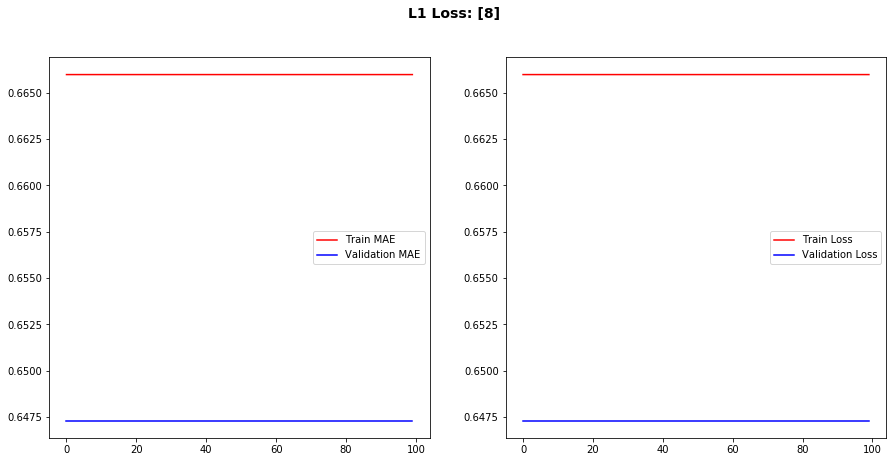

Hidden Layers: [16]
399/399 [==============================] - 0s 60us/step
Test Loss: 0.295218, Test MAE: 0.295218


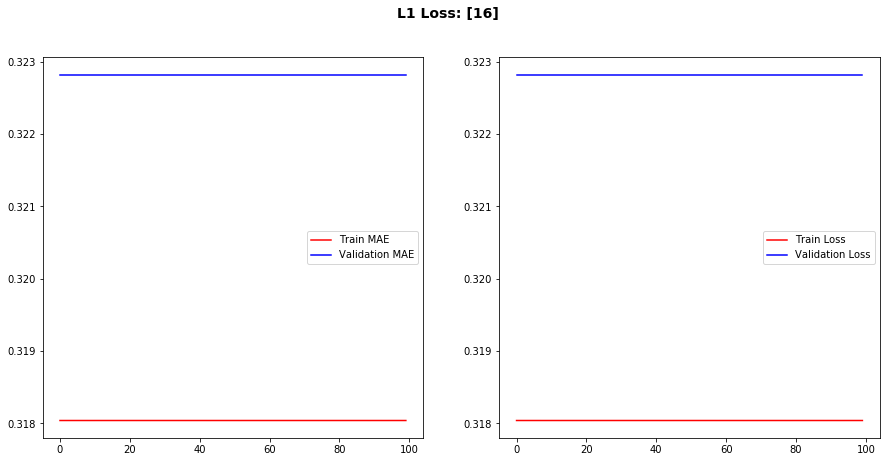

Hidden Layers: [8, 8]
399/399 [==============================] - 0s 60us/step
Test Loss: 0.952685, Test MAE: 0.952685


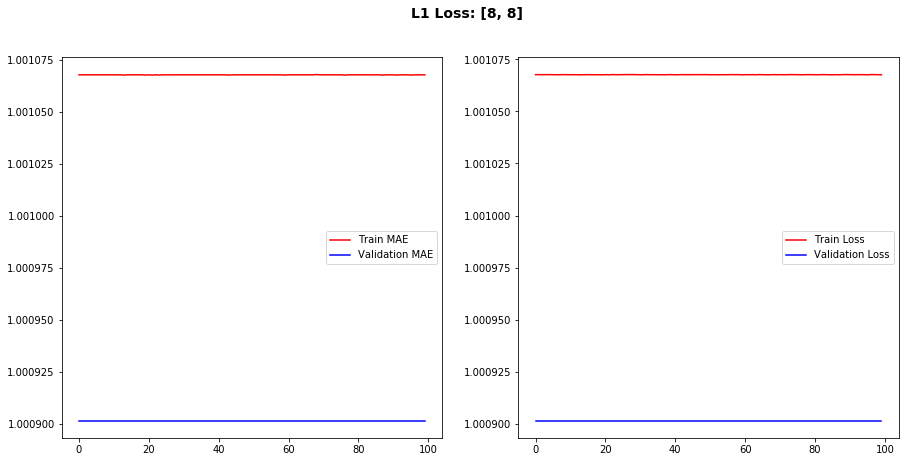

Hidden Layers: [8, 16]
399/399 [==============================] - 0s 60us/step
Test Loss: 0.191164, Test MAE: 0.191164


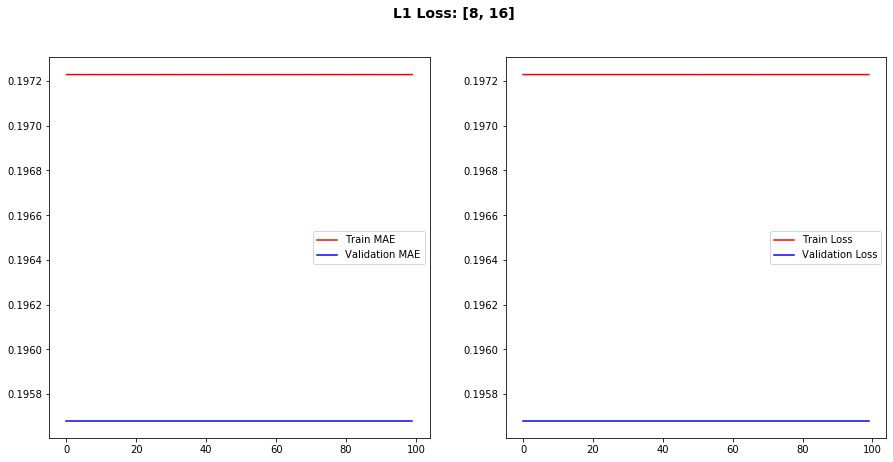

Building Model with Loss: L2
Hidden Layers: [8]
399/399 [==============================] - 0s 57us/step
Test Loss: 3.580785, Test MAE: 1.781330


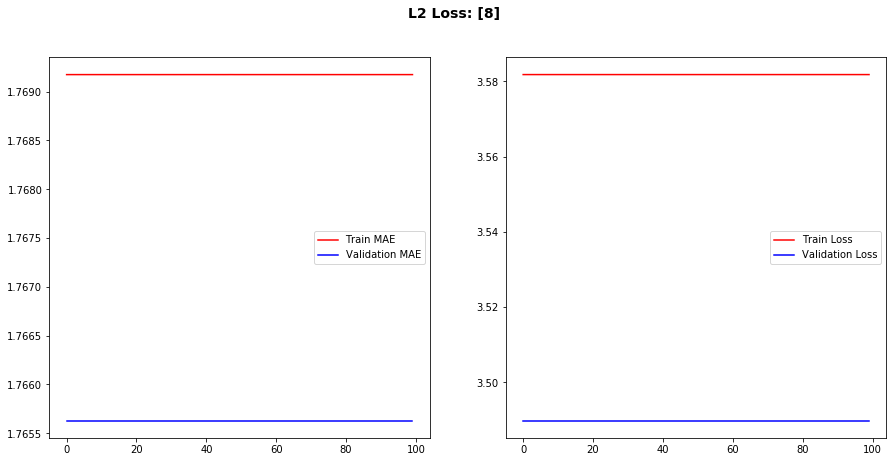

Hidden Layers: [16]
399/399 [==============================] - 0s 70us/step
Test Loss: 0.115338, Test MAE: 0.248064


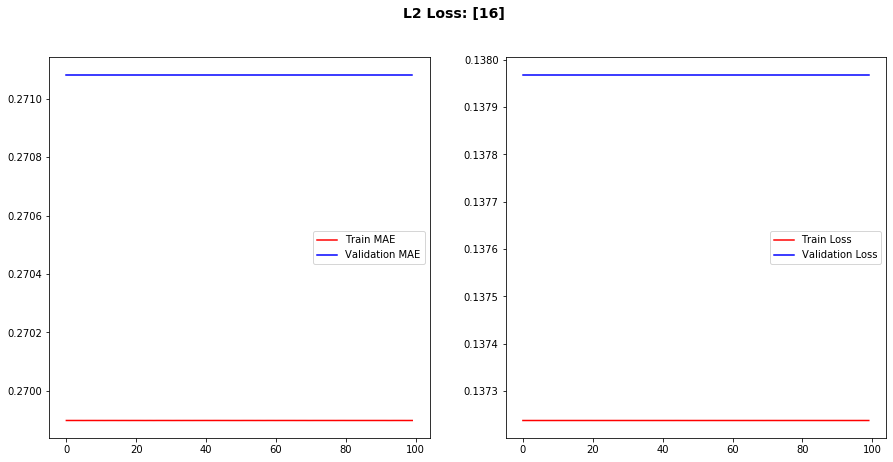

Hidden Layers: [8, 8]
399/399 [==============================] - 0s 60us/step
Test Loss: 1.338188, Test MAE: 1.109519


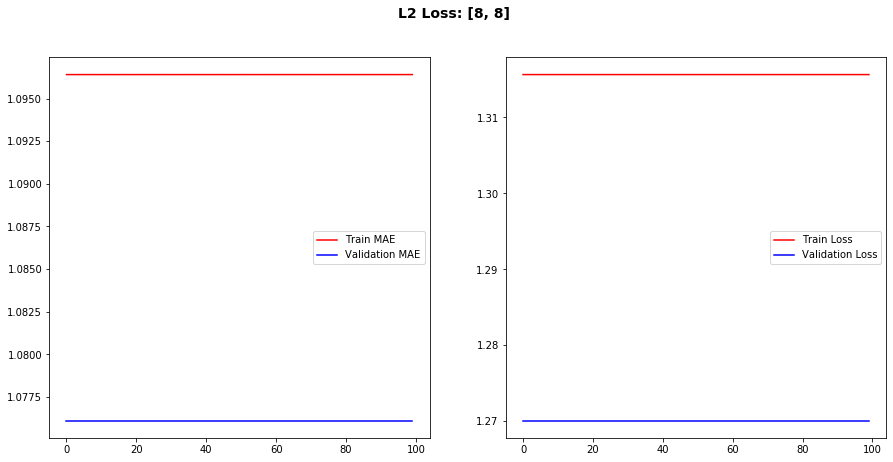

Hidden Layers: [8, 16]
399/399 [==============================] - 0s 70us/step
Test Loss: 0.252956, Test MAE: 0.420890


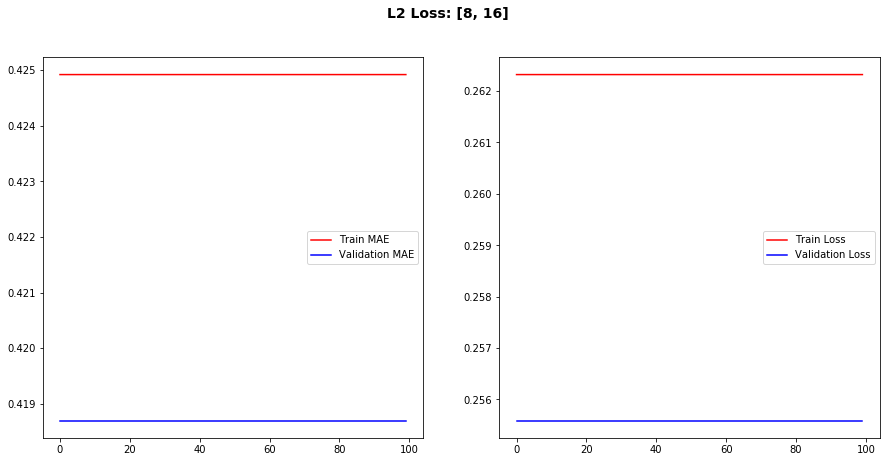

Building Model with Loss: huber
Hidden Layers: [8]
399/399 [==============================] - 0s 60us/step
Test Loss: 0.148287, Test MAE: 0.443228


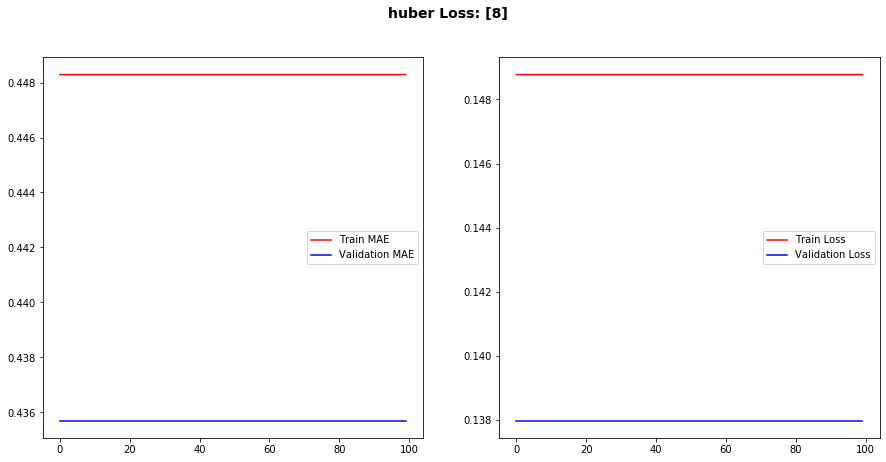

Hidden Layers: [16]
399/399 [==============================] - 0s 70us/step
Test Loss: 0.150898, Test MAE: 0.450790


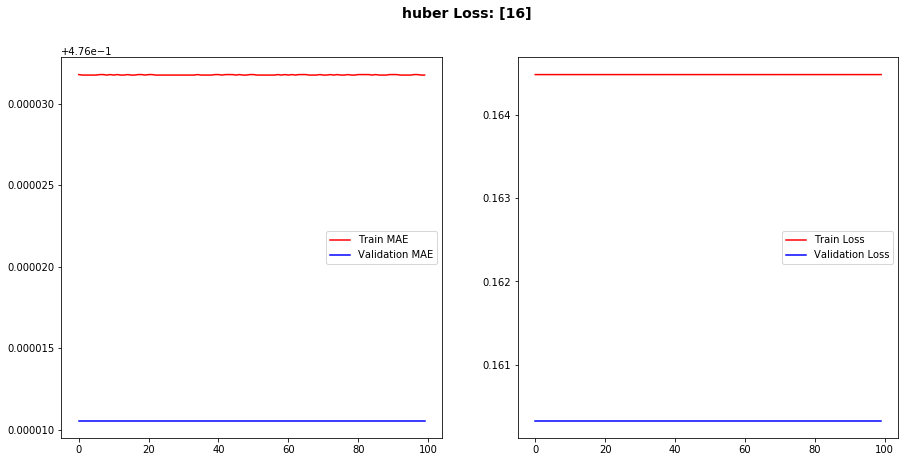

Hidden Layers: [8, 8]
399/399 [==============================] - 0s 54us/step
Test Loss: 0.172797, Test MAE: 0.532995


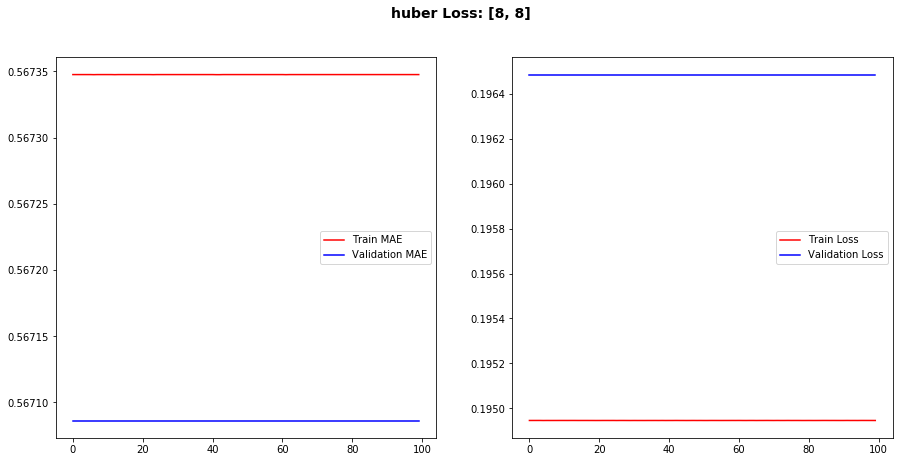

Hidden Layers: [8, 16]
399/399 [==============================] - 0s 100us/step
Test Loss: 0.052831, Test MAE: 0.258328


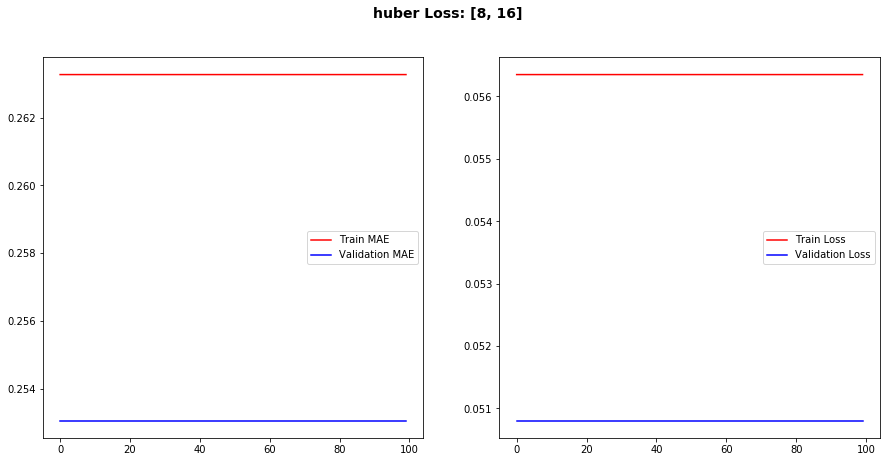

Building Model with Loss: logcosh
Hidden Layers: [8]
399/399 [==============================] - 0s 50us/step
Test Loss: 0.054926, Test MAE: 0.269975


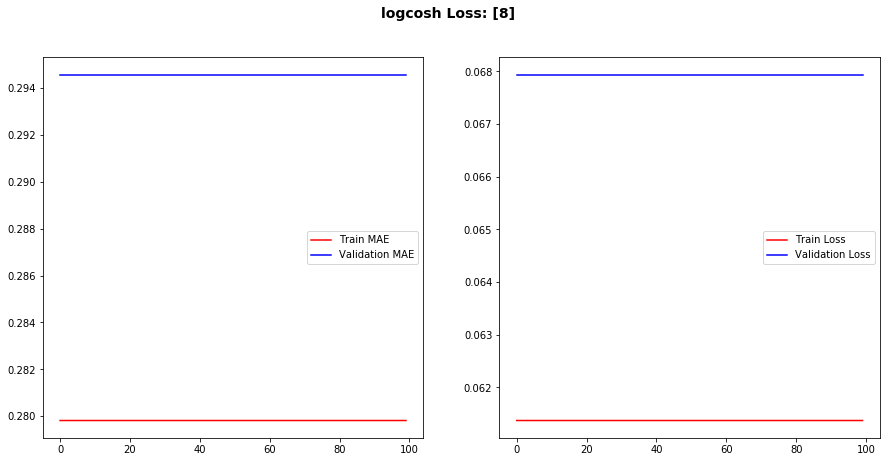

Hidden Layers: [16]
399/399 [==============================] - 0s 70us/step
Test Loss: 0.714209, Test MAE: 1.325263


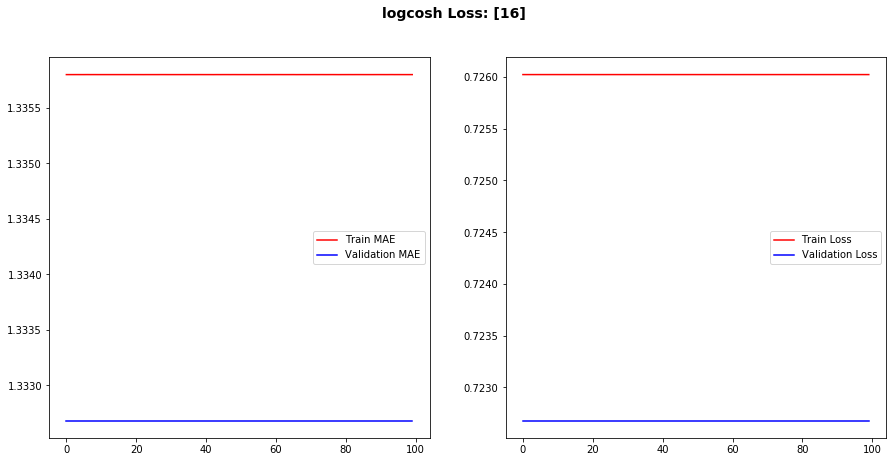

Hidden Layers: [8, 8]
399/399 [==============================] - 0s 70us/step
Test Loss: 0.099319, Test MAE: 0.383315


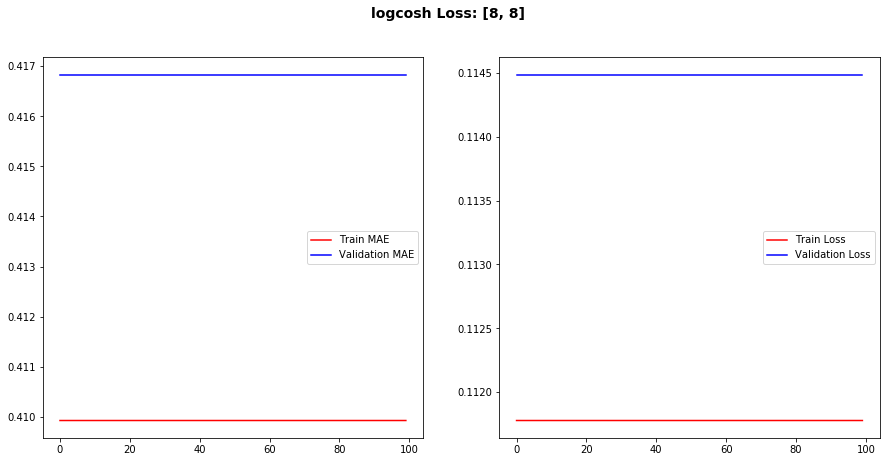

Hidden Layers: [8, 16]
399/399 [==============================] - 0s 94us/step
Test Loss: 0.037124, Test MAE: 0.203284


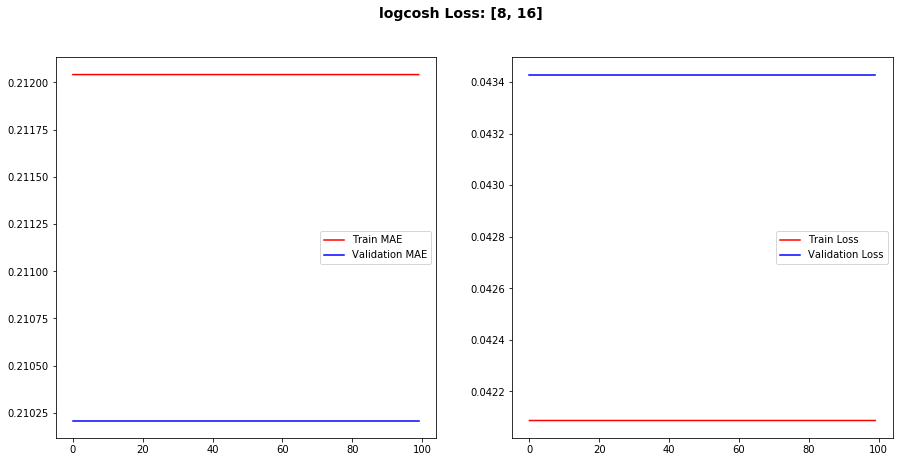

All Combinations:  {'L1': {'[8]': {'Test Loss': 0.7041290780356654, 'Test MAE': 0.7041290998458862}, '[16]': {'Test Loss': 0.2952183706121038, 'Test MAE': 0.2952183783054352}, '[8, 8]': {'Test Loss': 0.9526853570364472, 'Test MAE': 0.9526852965354919}, '[8, 16]': {'Test Loss': 0.19116405436867162, 'Test MAE': 0.1911640614271164}}, 'L2': {'[8]': {'Test Loss': 3.5807854376341166, 'Test MAE': 1.781329870223999}, '[16]': {'Test Loss': 0.11533817196997784, 'Test MAE': 0.24806393682956696}, '[8, 8]': {'Test Loss': 1.338188161826074, 'Test MAE': 1.1095194816589355}, '[8, 16]': {'Test Loss': 0.2529557672957131, 'Test MAE': 0.420890212059021}}, 'huber': {'[8]': {'Test Loss': 0.1482865667171347, 'Test MAE': 0.44322776794433594}, '[16]': {'Test Loss': 0.15089812579758485, 'Test MAE': 0.45078974962234497}, '[8, 8]': {'Test Loss': 0.17279711130418277, 'Test MAE': 0.5329946875572205}, '[8, 16]': {'Test Loss': 0.052830633186830914, 'Test MAE': 0.25832831859588623}}, 'logcosh': {'[8]': {'Test Loss': 0

In [13]:
# Tuning Loss Function

batch_size = 512
epochs = 100

losses = ['L1', 'L2', 'huber', 'logcosh']
hidden_layers = [[8], [16], [8,8], [8,16]]
metrics = {}
best_model = ""
min_so_far = np.inf
for i, loss in enumerate(losses):
  print("Building Model with Loss: " + loss)
  for j, hidden_layer in enumerate(hidden_layers):
    print("Hidden Layers: " + str(hidden_layer))
    model = define_model(num_layers = len(hidden_layer), num_neurons = hidden_layer, 
                         input_shape = (x_train.shape[1],), loss = loss)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    test_output = model.evaluate(x_test, y_test)
    if test_output[1] < min_so_far:
      min_so_far = test_output[1]
      best_model = "Loss: " + loss + ", Hidden Layers: " + str(hidden_layer)
    if loss in metrics.keys():
      if len(metrics['L1']) < 1:
        metrics[loss] = {str(hidden_layer) : {"Test Loss" : test_output[0], "Test MAE" : test_output[1]}}
      else:
        metrics[loss].update({str(hidden_layer) : {"Test Loss" : test_output[0], "Test MAE" : test_output[1]}})
    else:
      metrics[loss] = {str(hidden_layer) : {"Test Loss" : test_output[0], "Test MAE" : test_output[1]}}
    print("Test Loss: %f, Test MAE: %f" % (test_output[0], test_output[1]))
    print_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = loss + " Loss: " + str(hidden_layer))



print("All Combinations: ", metrics)

print("Best Model for loss: ",best_model)



#Best Model for loss:  Loss: L1, Hidden Layers: [8, 16]

Building Model with Optimizer: sgd
Learning Rate: 0.001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


399/399 [==============================] - 0s 60us/step


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Test Loss: 0.160897, Test MAE: 0.160897


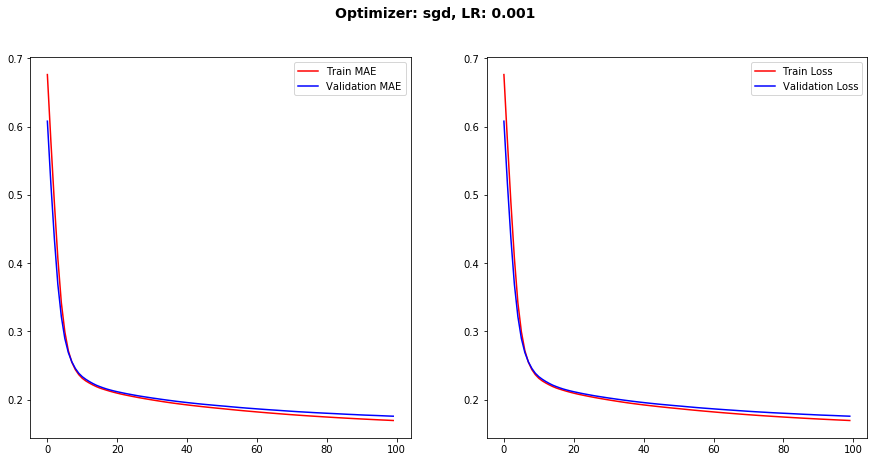

Learning Rate: 0.005
399/399 [==============================] - 0s 70us/step
Test Loss: 0.149226, Test MAE: 0.149226


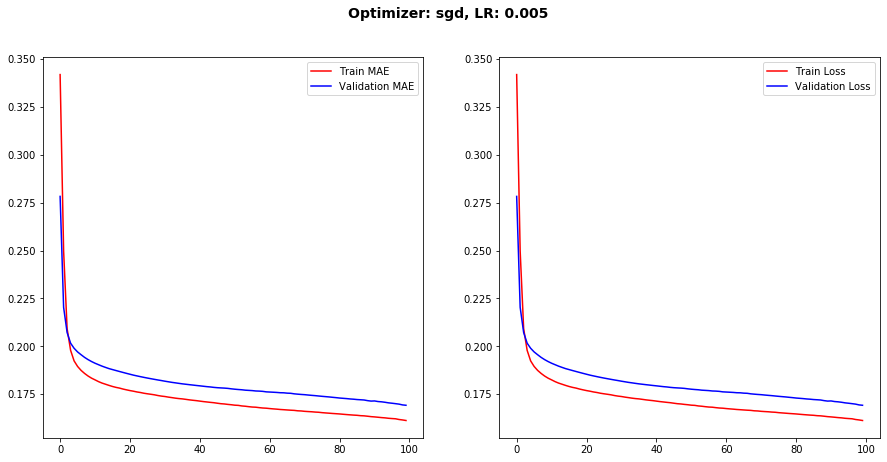

Learning Rate: 0.01
399/399 [==============================] - 0s 80us/step
Test Loss: 0.106952, Test MAE: 0.106952


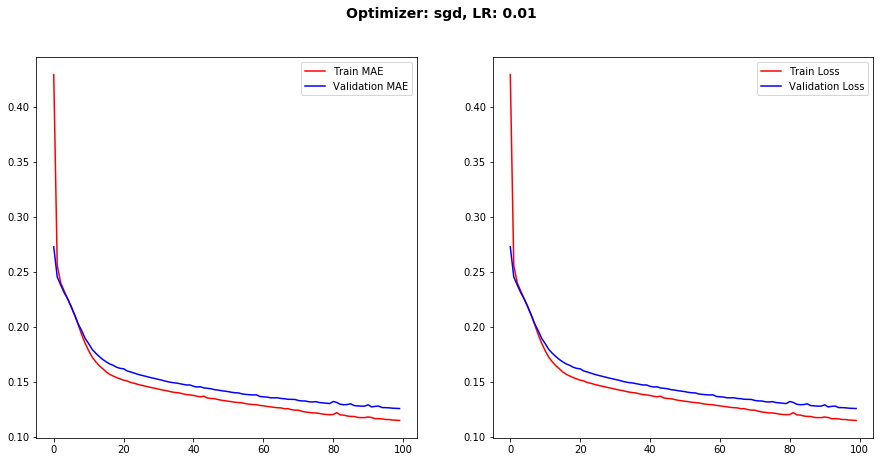

Learning Rate: 0.05
399/399 [==============================] - 0s 341us/step
Test Loss: 0.096793, Test MAE: 0.096793


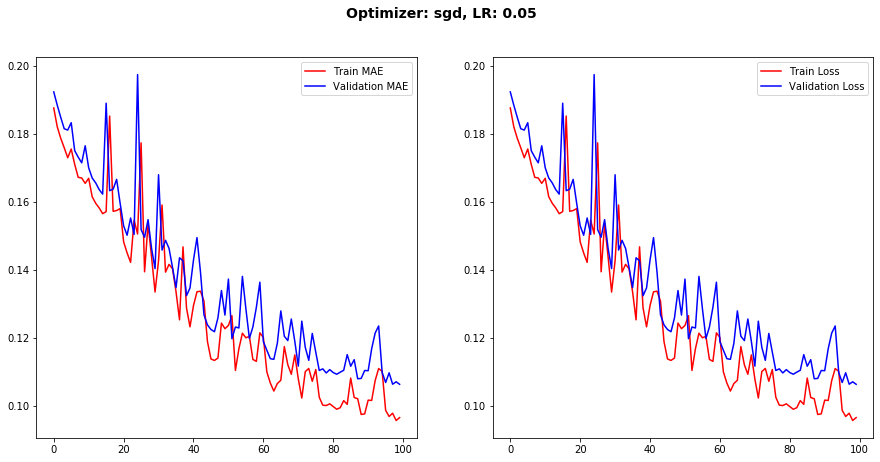

Building Model with Optimizer: RMSprop
Learning Rate: 0.001
399/399 [==============================] - 0s 70us/step
Test Loss: 0.096411, Test MAE: 0.096411


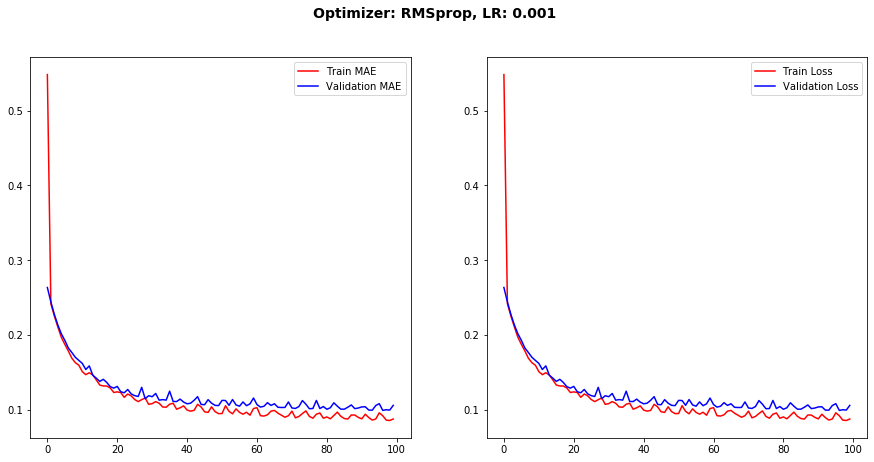

Learning Rate: 0.005
399/399 [==============================] - 0s 70us/step
Test Loss: 0.093156, Test MAE: 0.093156


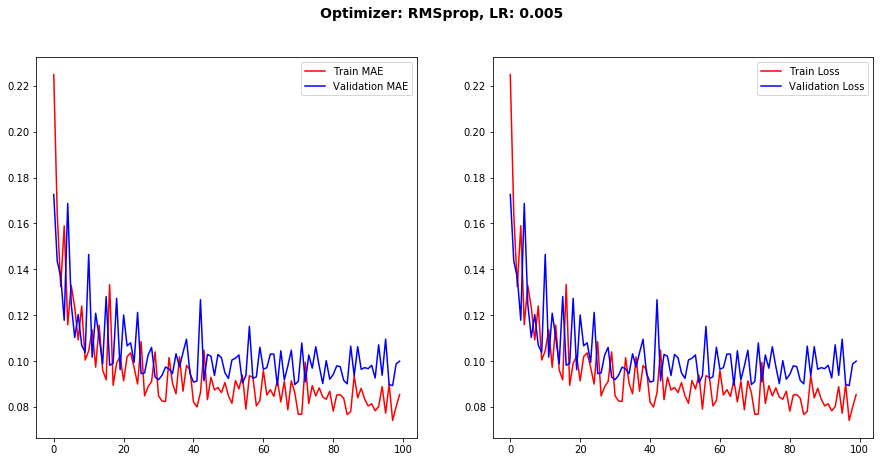

Learning Rate: 0.01
399/399 [==============================] - 0s 80us/step
Test Loss: 0.097641, Test MAE: 0.097641


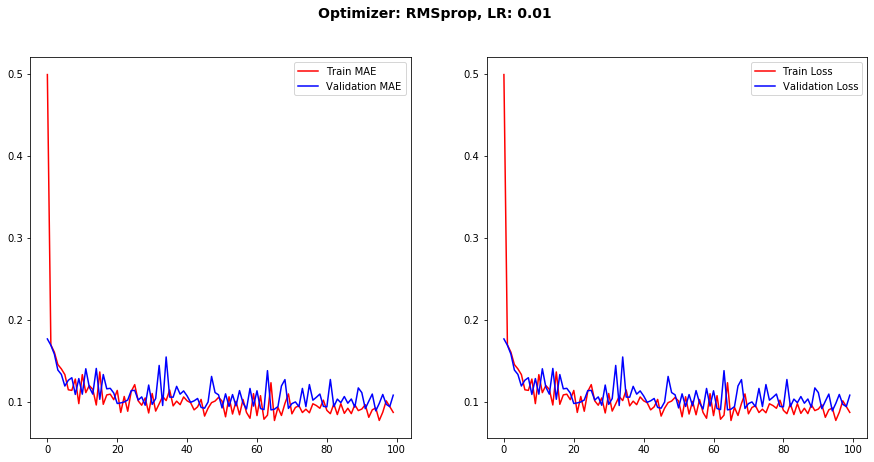

Learning Rate: 0.05
399/399 [==============================] - 0s 70us/step
Test Loss: 0.165063, Test MAE: 0.165063


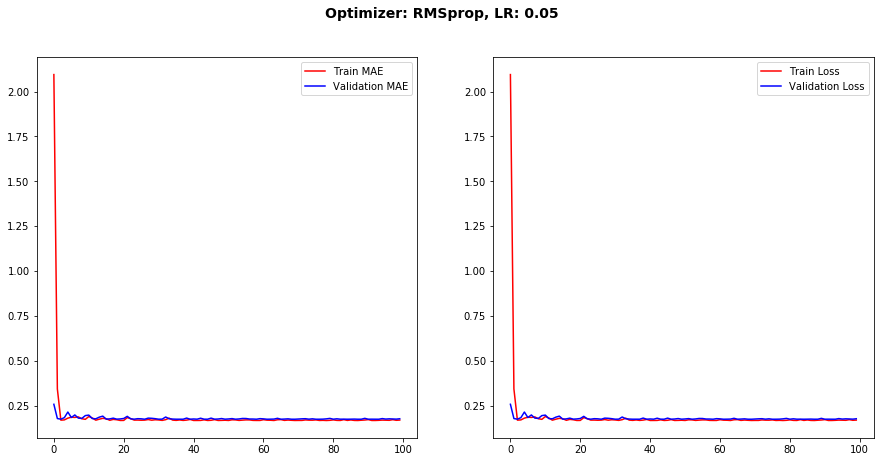

Building Model with Optimizer: Adagrad
Learning Rate: 0.001
399/399 [==============================] - 0s 50us/step
Test Loss: 0.122986, Test MAE: 0.122986


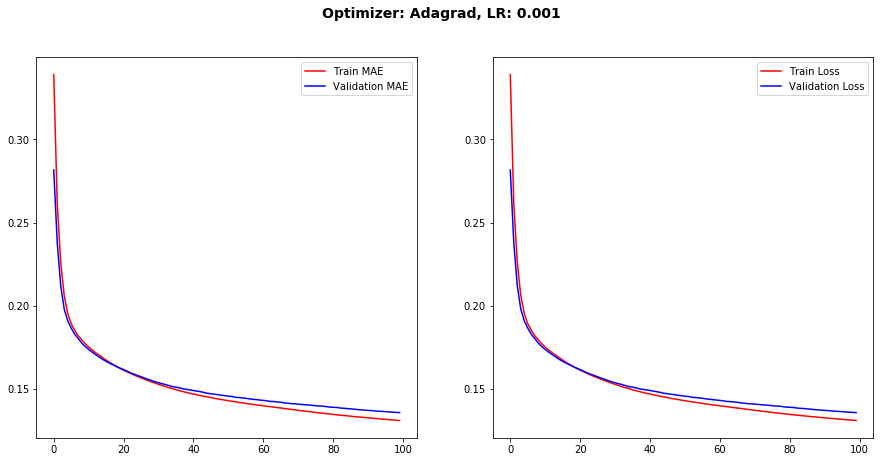

Learning Rate: 0.005
399/399 [==============================] - 0s 50us/step
Test Loss: 0.093585, Test MAE: 0.093585


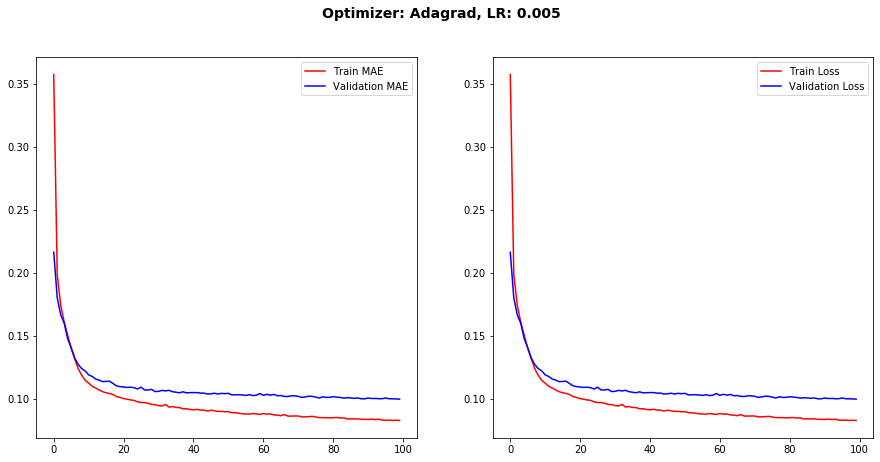

Learning Rate: 0.01
399/399 [==============================] - 0s 60us/step
Test Loss: 0.087333, Test MAE: 0.087333


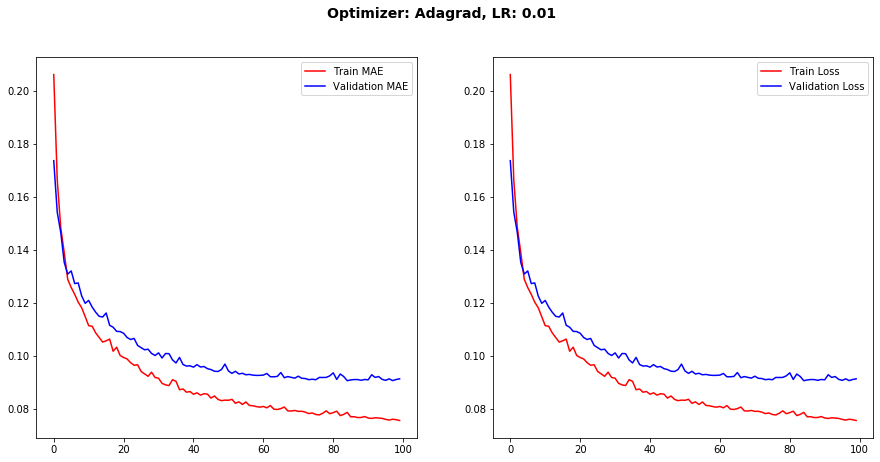

Learning Rate: 0.05
399/399 [==============================] - 0s 90us/step
Test Loss: 0.086724, Test MAE: 0.086724


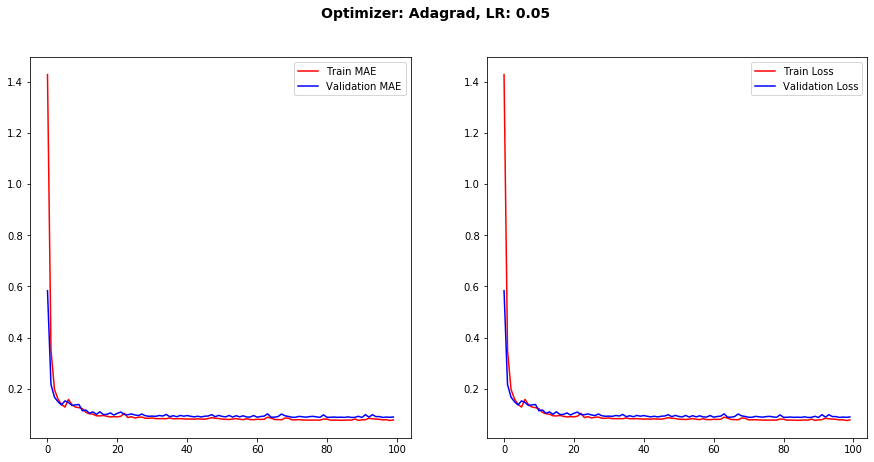

  Optimizer                            0.001                            0.005  \
0       sgd  {'MAE': 0.1609, 'Time': 6.5649}  {'MAE': 0.1492, 'Time': 6.3613}   
1   RMSprop  {'MAE': 0.0964, 'Time': 7.7715}  {'MAE': 0.0932, 'Time': 6.9404}   
2   Adagrad   {'MAE': 0.123, 'Time': 6.9133}  {'MAE': 0.0936, 'Time': 7.1274}   

                              0.01                             0.05  
0   {'MAE': 0.107, 'Time': 6.3318}  {'MAE': 0.0968, 'Time': 7.4219}  
1  {'MAE': 0.0976, 'Time': 6.5031}   {'MAE': 0.1651, 'Time': 6.427}  
2  {'MAE': 0.0873, 'Time': 6.9592}  {'MAE': 0.0867, 'Time': 7.9225}  


In [14]:
#Optimizers

batch_size = 512
epochs = 100

opts = ['sgd', 'RMSprop', 'Adagrad']
lrs = [0.001, 0.005, 0.01, 0.05]

col_names =  ['Optimizer', '0.001', '0.005', '0.01', '0.05']
metrics = pd.DataFrame({}, index=np.arange(len(opts)), columns=col_names)
best_model = ""
min_so_far = np.inf
for i, opt in enumerate(opts):
  print("Building Model with Optimizer: " + opt)
  metrics.loc[i][0] = opt
  for j, lr in enumerate(lrs):
    print("Learning Rate: " + str(lr))
    start = time.clock()
    model = define_model(num_layers = 2, num_neurons = [8, 16], 
                         input_shape = (x_train.shape[1],), loss = "L1",
                        optimizer = opt, optimizer_lr = lr)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    time_taken = time.clock() - start
    test_output = model.evaluate(x_test, y_test)
    metrics.loc[i][j+1]  = {'MAE' : round(test_output[1], 4), 
                          'Time': round(time_taken, 4)}
    if test_output[1] < min_so_far:
      min_so_far = test_output[1]
      best_model = "Optimizer: " + opt + ", Learning Rate: " + str(lr)
    print("Test Loss: %f, Test MAE: %f" % (test_output[0], test_output[1]))
    print_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Optimizer: " + opt + ", LR: " + str(lr))


print(metrics)


Building Model with l1 weight decay
Regularization Rate: 0.001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


399/399 [==============================] - 0s 70us/step


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Test Loss: 0.119020, Test MAE: 0.091787


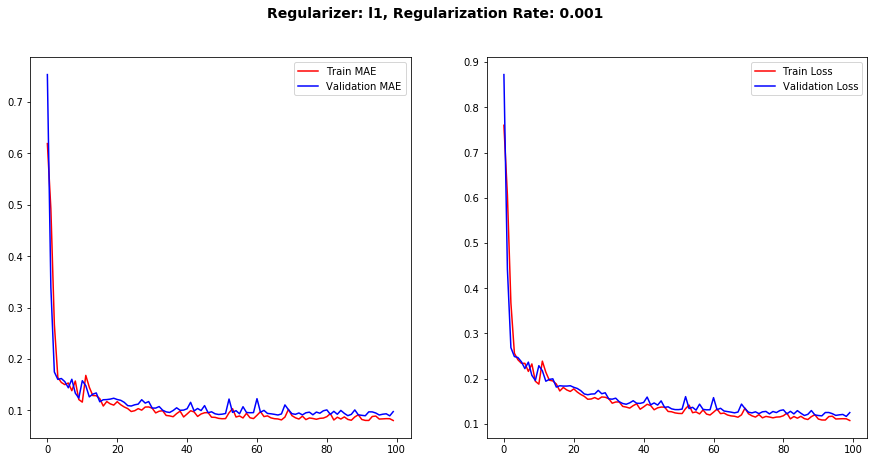

Regularization Rate: 0.005
399/399 [==============================] - 0s 70us/step
Test Loss: 0.134574, Test MAE: 0.088501


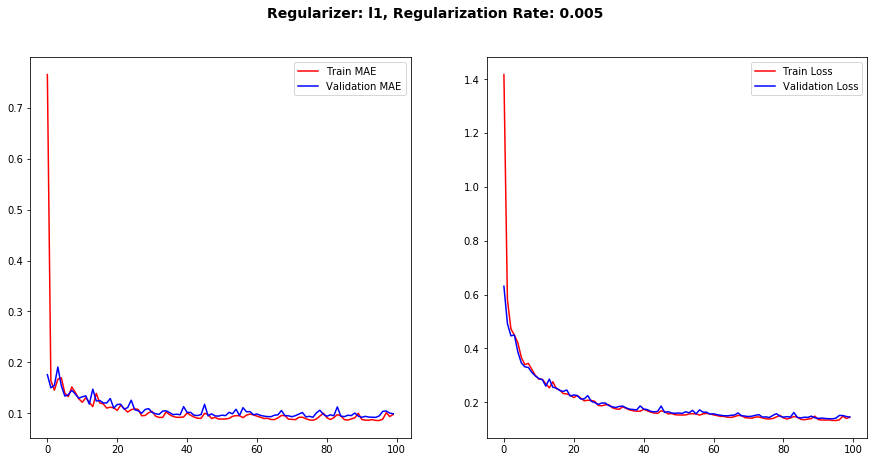

Regularization Rate: 0.01
399/399 [==============================] - 0s 70us/step
Test Loss: 0.176422, Test MAE: 0.115854


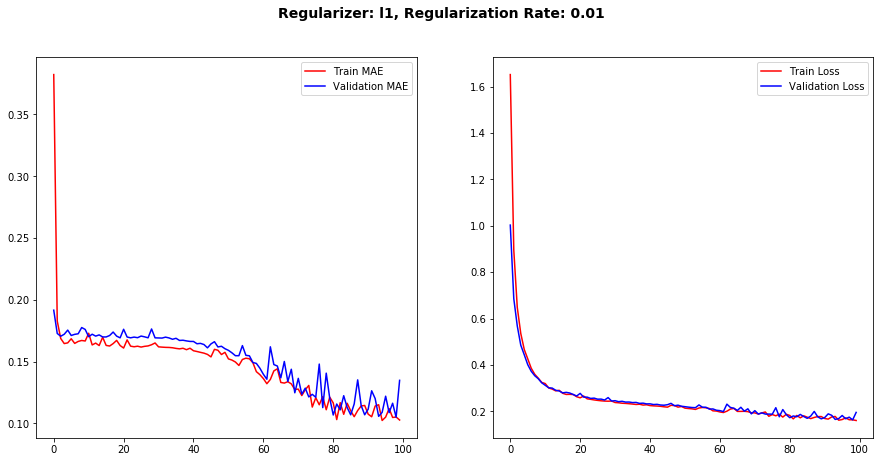

Regularization Rate: 0.05
399/399 [==============================] - 0s 70us/step
Test Loss: 0.234314, Test MAE: 0.153465


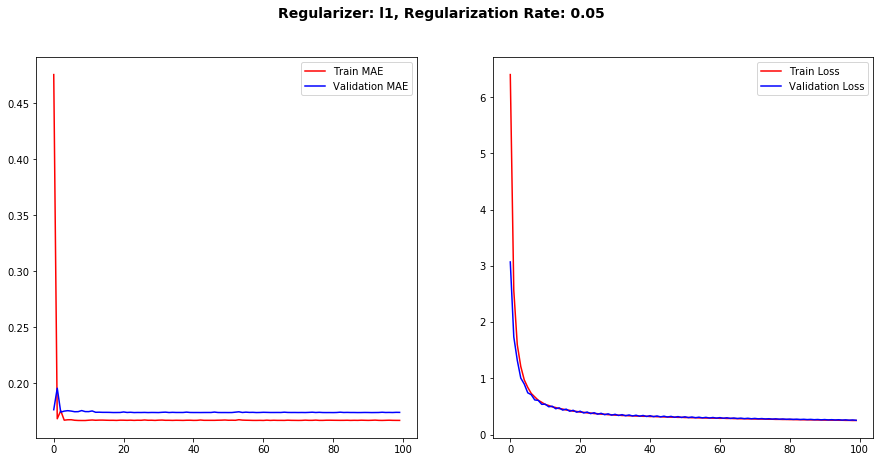

Building Model with l2 weight decay
Regularization Rate: 0.001
399/399 [==============================] - 0s 90us/step
Test Loss: 0.098819, Test MAE: 0.086468


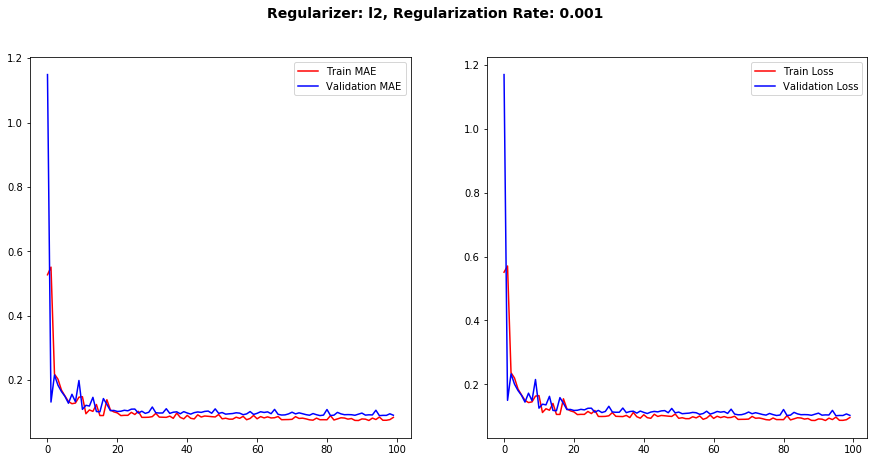

Regularization Rate: 0.005
399/399 [==============================] - 0s 80us/step
Test Loss: 0.099331, Test MAE: 0.086185


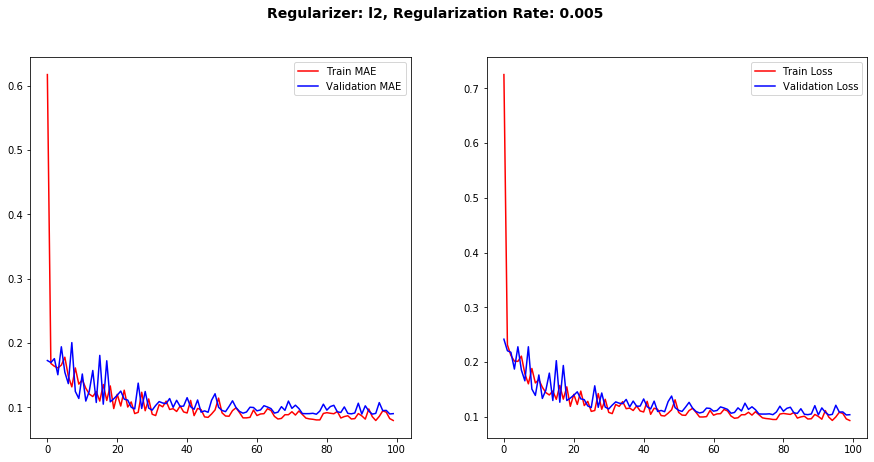

Regularization Rate: 0.01
399/399 [==============================] - 0s 90us/step
Test Loss: 0.110707, Test MAE: 0.084678


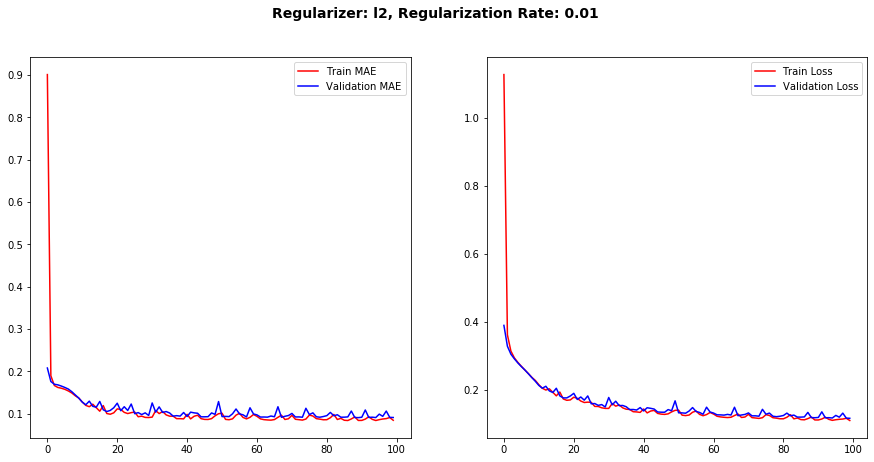

Regularization Rate: 0.05
399/399 [==============================] - 0s 80us/step
Test Loss: 0.120447, Test MAE: 0.089638


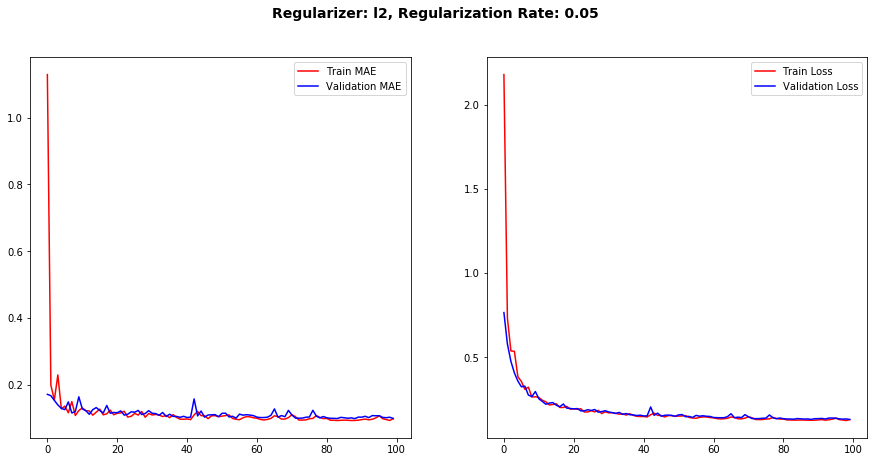

Building Model with l1_l2 weight decay
Regularization Rate: 0.001
399/399 [==============================] - 0s 80us/step
Test Loss: 0.121262, Test MAE: 0.086783


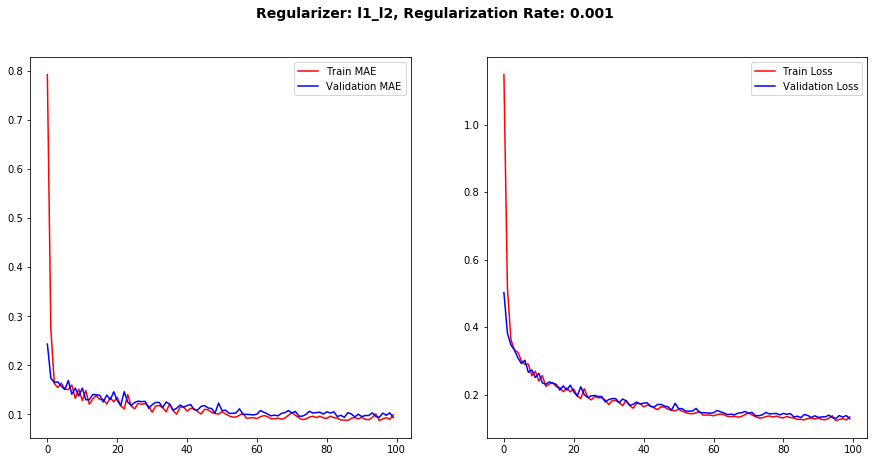

Regularization Rate: 0.005
399/399 [==============================] - 0s 80us/step
Test Loss: 0.138869, Test MAE: 0.086353


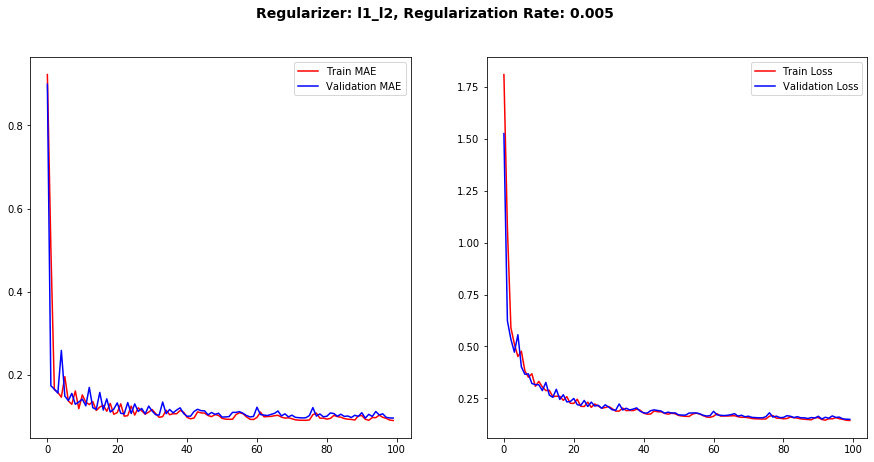

Regularization Rate: 0.01
399/399 [==============================] - 0s 80us/step
Test Loss: 0.175273, Test MAE: 0.153852


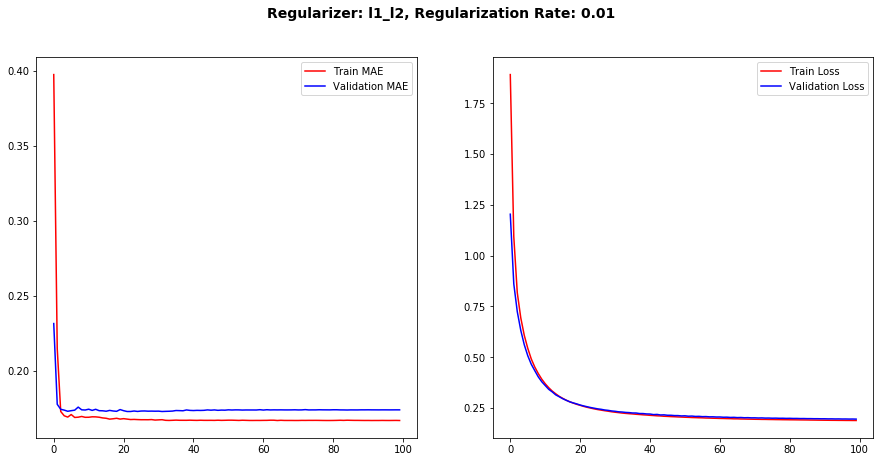

Regularization Rate: 0.05
399/399 [==============================] - 0s 90us/step
Test Loss: 0.224212, Test MAE: 0.153968


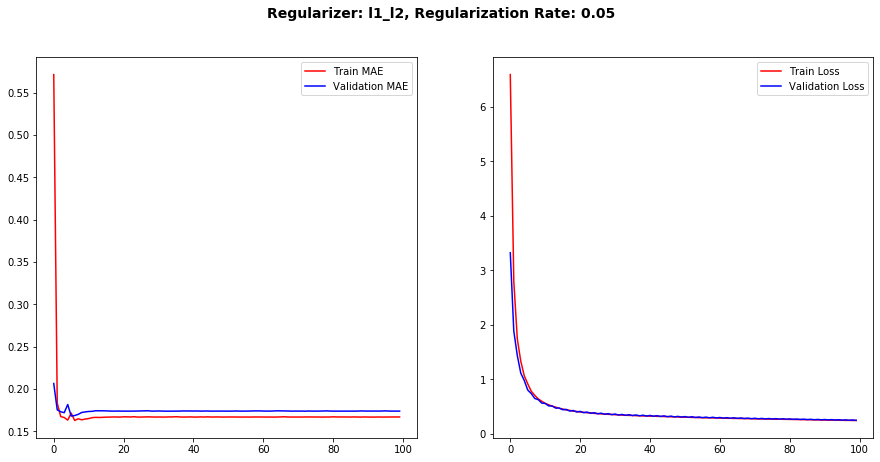

All Combinations:                                0.001            0.005            0.010  \
L1 Weight Decay     {'MAE': 0.0918}  {'MAE': 0.0885}  {'MAE': 0.1159}   
L2 Weight Decay     {'MAE': 0.0865}  {'MAE': 0.0862}  {'MAE': 0.0847}   
L1_L2 Weight Decay  {'MAE': 0.0868}  {'MAE': 0.0864}  {'MAE': 0.1539}   

                              0.050  
L1 Weight Decay     {'MAE': 0.1535}  
L2 Weight Decay     {'MAE': 0.0896}  
L1_L2 Weight Decay   {'MAE': 0.154}  
Best Model for Weight Decay:  Regularizer: l2, Regularization Rate: 0.01


In [15]:
#Weight Decay

batch_size = 512
epochs = 100

regs = ['l1', 'l2', 'l1_l2']
reg_rates = [0.001, 0.005, 0.01, 0.05]
indexes =  ['L1 Weight Decay', 'L2 Weight Decay', 'L1_L2 Weight Decay']
metrics = pd.DataFrame({}, index=indexes, columns=reg_rates)
best_model = ""
min_so_far = np.inf
for i, regularizer in enumerate(regs):
  print("Building Model with " + regularizer + " weight decay")
  #metrics.loc[i][0] = opt
  for j, reg_rate in enumerate(reg_rates):
    print("Regularization Rate: " + str(reg_rate))
    start = time.clock()
    model = define_model(num_layers = 2, num_neurons = [8, 16], 
                         input_shape = (x_train.shape[1],), loss = "L1",
                        optimizer = opt, optimizer_lr = lr,
                        regularizer = regularizer, reg_rate = reg_rate)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    time_taken = time.clock() - start
    test_output = model.evaluate(x_test, y_test)
    metrics.loc[indexes[i]][reg_rates[j]]  = {'MAE' : round(test_output[1], 4)}
    
    if test_output[1] < min_so_far:
      min_so_far = test_output[1]
      best_model = "Regularizer: " + regularizer + ", Regularization Rate: " + str(reg_rate)
    print("Test Loss: %f, Test MAE: %f" % (test_output[0], test_output[1]))
    print_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Regularizer: " + regularizer + ", Regularization Rate: " + str(reg_rate))


print("All Combinations: ", metrics)

print("Best Model for Weight Decay: ",best_model)


Best Model for Weight Decay:  Regularizer: l2, Regularization Rate: 0.01

Building Model with Dropout level: 0.2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


319/319 [==============================] - 0s 88us/step


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Test Loss: 0.018544, Test MAE: 0.126831


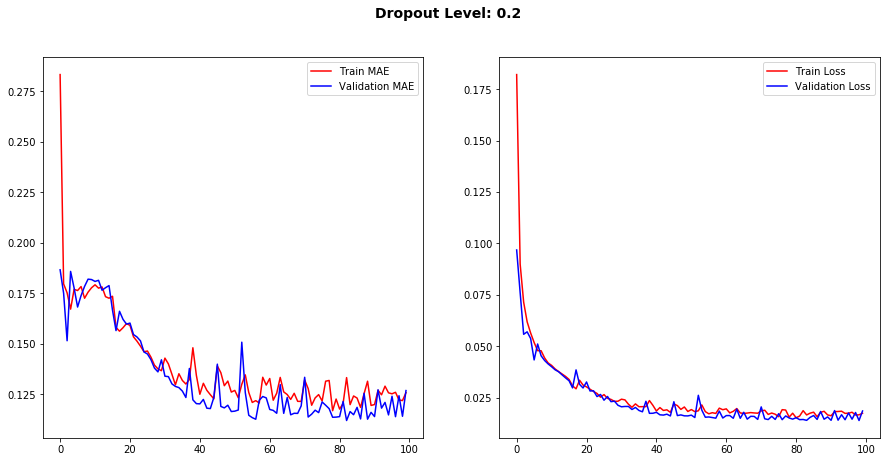

Building Model with Dropout level: 0.25
319/319 [==============================] - 0s 88us/step
Test Loss: 0.015166, Test MAE: 0.110391


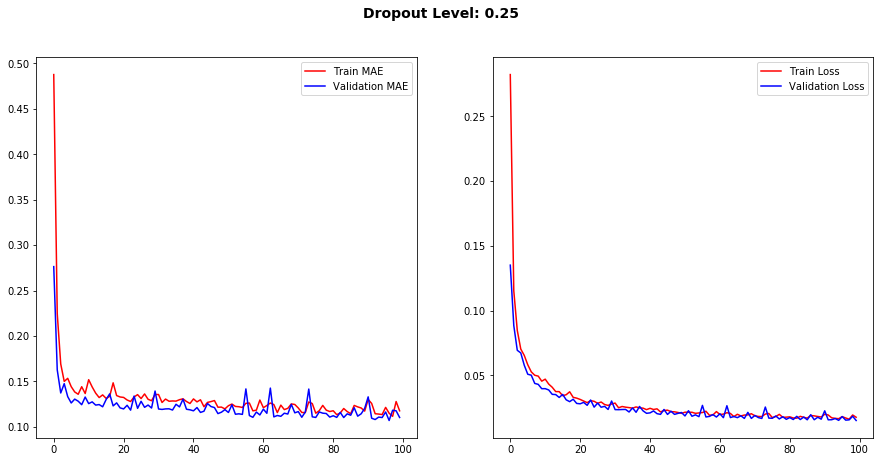

Building Model with Dropout level: 0.3
319/319 [==============================] - 0s 88us/step
Test Loss: 0.019175, Test MAE: 0.115084


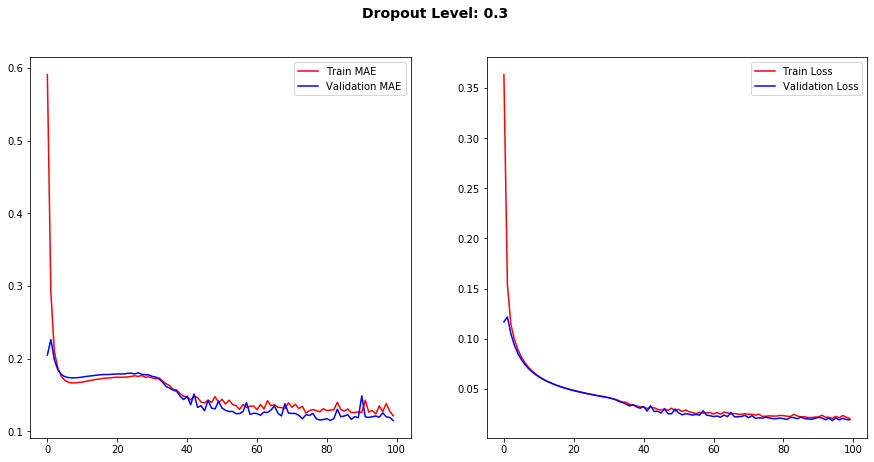

Building Model with Dropout level: 0.35
319/319 [==============================] - 0s 88us/step
Test Loss: 0.017980, Test MAE: 0.122115


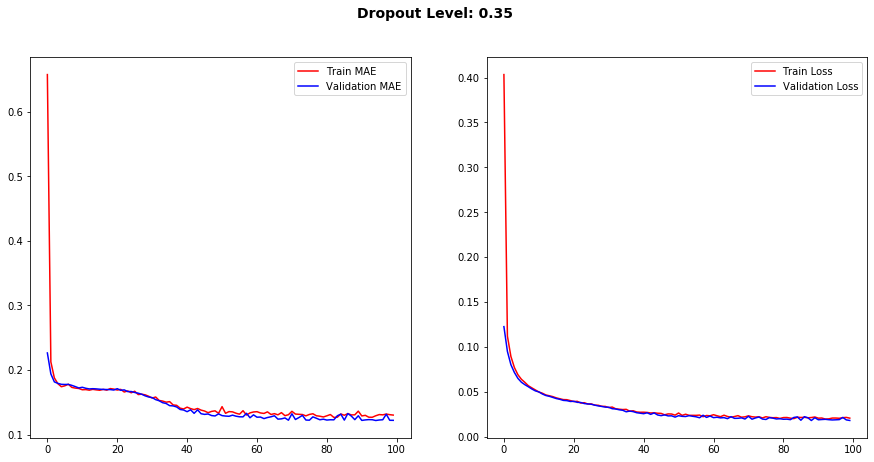

Building Model with Dropout level: 0.39999999999999997
319/319 [==============================] - 0s 88us/step
Test Loss: 0.018413, Test MAE: 0.135286


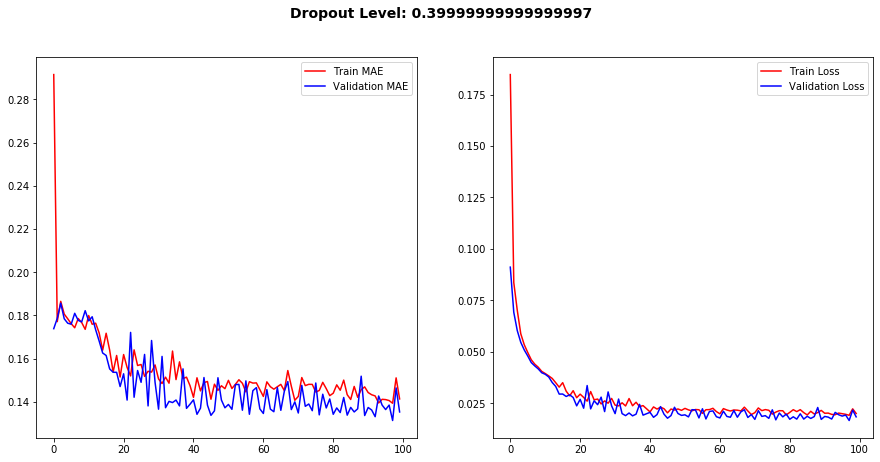

Building Model with Dropout level: 0.44999999999999996
319/319 [==============================] - 0s 88us/step
Test Loss: 0.017325, Test MAE: 0.126298


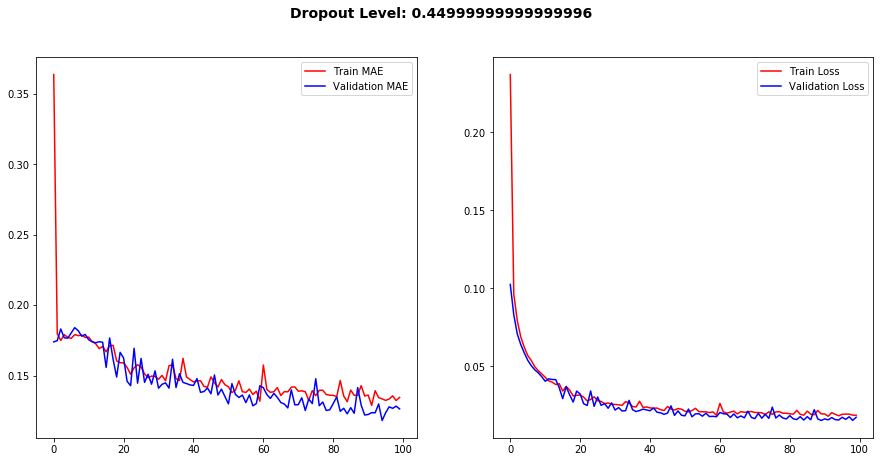

Building Model with Dropout level: 0.49999999999999994
319/319 [==============================] - 0s 88us/step
Test Loss: 0.017521, Test MAE: 0.128183


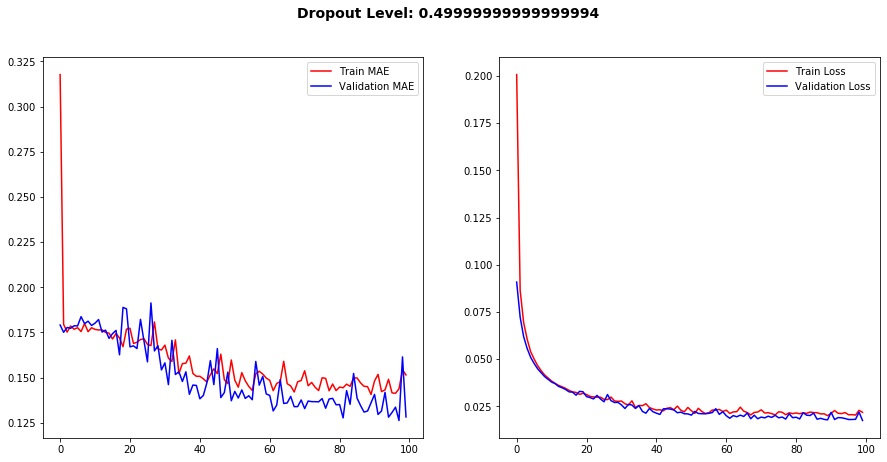

All Combinations:           MAE
0.20  0.1268
0.25  0.1104
0.30  0.1151
0.35  0.1221
0.40  0.1353
0.45  0.1263
0.50  0.1282
Best Model for Dropouts:  Dropout: 0.25


In [17]:
#Dropout


batch_size = 512
epochs = 100

dropouts = np.arange(0.2, 0.55, 0.05)
indexes =  ['L1 Weight Decay', 'L2 Weight Decay', 'L1_L2 Weight Decay']
metrics = pd.DataFrame(0.0, index=dropouts, columns=['MAE'])
best_model = ""
min_so_far = np.inf
for i, dropout in enumerate(dropouts):
  print("Building Model with Dropout level: " + str(dropout))
  #metrics.loc[i][0] = opt
  start = time.clock()
  model = define_model(num_layers = 2, num_neurons = [8, 16], 
                       input_shape = (x_train.shape[1],), loss = "logcosh",
                       optimizer = opt, optimizer_lr = lr,
                       regularizer = 'l2', reg_rate = 0.005,
                       dropout = dropout)
  history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
  time_taken = time.clock() - start
  test_output = model.evaluate(x_val, y_val)
  metrics.loc[dropouts[i]]['MAE']  = round(test_output[1], 4)
    
  if test_output[1] < min_so_far:
    min_so_far = test_output[1]
    best_model = "Dropout: " + str(dropout)
  print("Test Loss: %f, Test MAE: %f" % (test_output[0], test_output[1]))
  print_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Dropout Level: " + str(dropout))


print("All Combinations: ", metrics)

print("Best Model for Dropouts: ",best_model)


319/319 [==============================] - 0s 88us/step
Test Loss: 0.027381, Test MAE: 0.168996


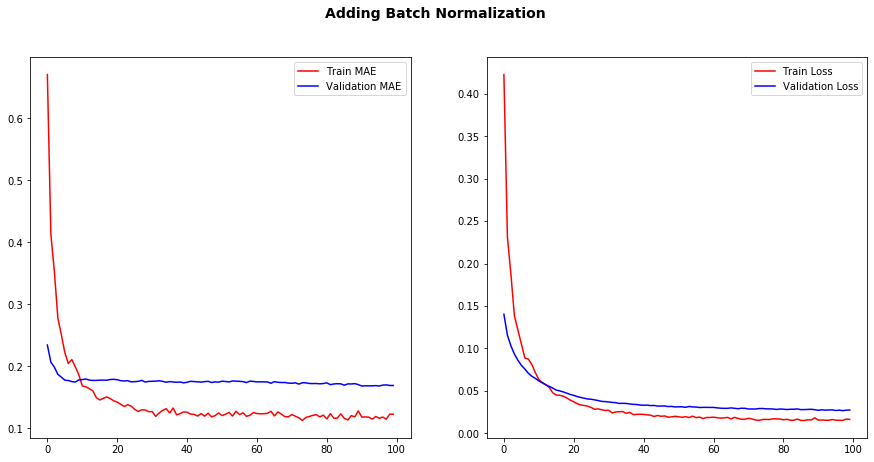

In [18]:
# final model
model = define_model(num_layers = 2, num_neurons = [8, 16], 
                       input_shape = (x_train.shape[1],), loss = "logcosh",
                       optimizer = opt, optimizer_lr = lr,
                       regularizer = 'l2', reg_rate = 0.005,
                       dropout = dropout, batch_norm = True)
history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
test_output = model.evaluate(x_val, y_val)
print("Test Loss: %f, Test MAE: %f" % (test_output[0], test_output[1]))
print_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Adding Batch Normalization")